Data Generation

Data was generated in 2 steps:

1.Initial Data was captured internally via Google Form which asked users for car issues they currently have or had in the past
Classified that data into: brakes, starter, other

2.Took this 'training set' and used Markovify to generate more data for our tutorial

In [1]:
!pip install -r requirements.txt

     |████████████████████████████████| 1.4 MB 41.2 MB/s eta 0:00:01
     |████████████████████████████████| 737 kB 94.3 MB/s eta 0:00:01
     |████████████████████████████████| 12.9 MB 100.4 MB/s eta 0:00:01
     |████████████████████████████████| 241 kB 128.7 MB/s eta 0:00:01
     |████████████████████████████████| 74 kB 97.4 MB/s  eta 0:00:01
     |████████████████████████████████| 458 kB 125.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 119.5 MB/s eta 0:00:01
     |████████████████████████████████| 130 kB 130.2 MB/s eta 0:00:01
     |████████████████████████████████| 9.8 MB 134.6 MB/s eta 0:00:01
     |████████████████████████████████| 12.2 MB 110.9 MB/s eta 0:00:01
     |████████████████████████████████| 113 kB 129.9 MB/s eta 0:00:01
  Created wheel for markovify: filename=markovify-0.9.0-py3-none-any.whl size=18476 sha256=effc60e4e5c257148806da999949099e4f2bfea0ea4848624691e8a224d68842
  Stored in directory: /tmp/pip-ephem-wheel-cache-egc3_bq8/wheels/cf/19/41/

In [4]:
import pandas as pd

df = pd.read_csv('response.csv') 
df = df.fillna('')
df['response']=df.iloc[:,3]+df.iloc[:,5]+df.iloc[:,6]
df['issue'] = df.iloc[:,1]
df['symptom'] = df.iloc[:,2] + df.iloc[:,4]
subset = df.iloc[:,-3:]
subset

,response,issue,symptom
0,my brakes make a noise whenever I try to stop,Brakes,Car makes grinding noise
1,super frustrating every time I start my car it...,Starter,Car starts then stops
2,I can't open the damn door to my car,Other,
3,I turn the key and nothing happens,Starter,Car doesn't start
4,Car doesn't always start when it's low on blin...,Starter,Car doesn't start
...,...,...,...
104,my breaks are faulty.,Brakes,"Car brakes, but then brakes disengage"
105,my lights do not work,Other,
106,I try to start the engine only to find that th...,Starter,Car doesn't start
107,The driver side window auto function does not ...,Other,


In [5]:
import markovify
import codecs

In [6]:
#markovify is a simple, extensible Markov chain generator
#Its primary use is for building Markov models of large corpora of text and generating random sentences from that.


#Function builds the model according to what issue (e.g. brakes, starter, other) is given
def train_markov_type(data, issue):
    return markovify.Text(data[data["issue"] == issue].response, retain_original=False, state_size=2)

#Function takes one of the 'issue' models and creates a randomly-generated sentence of length up to 200 characters.  Note only creates '1' sentence
def make_sentence(model, length=100):
    return model.make_short_sentence(length, max_overlap_ratio = .7, max_overlap_total=15)

other_model = train_markov_type(subset, "Other")
brakes_model = train_markov_type(subset, "Brakes")
starter_model = train_markov_type(subset, "Starter")

In [7]:
make_sentence(other_model)  #creates a sentence that should be an example of 'other' issue(category)

'I was working on the left door is scratched.'

In [8]:
make_sentence(brakes_model)  #creates a sentence that should be an example of 'brakes' issue(category)

'It was really cold out and I could not get the emergency brake to disengage.'

In [9]:
make_sentence(starter_model)   #creates a sentence that should be an example of 'starter' issue(category)

"Car doesn't always start when it's low on blinker fluid"

We can combine these models with relative weights

In [10]:
#create a compound model in which the sentences that come out will be 2x as many 'other' than 'brakes' or 'starters'

compound_model = markovify.combine([other_model, brakes_model, starter_model], [14, 7, 7])  

In [11]:
#make 20 sentences out of the compound model - copy the text into a spreadsheet and check the count of the issues  (e.g. how many brake issue are there?)

for i in range(28):
    print(make_sentence(compound_model))

The car won't shift out of park.
The car pulls to the car to turn over.
I try to stop as quickly as it used to
The car is very unsafe.
Plus it seems like the car to turn everything off, everything stays on.
When it rains, the car is behaving very weird.
It makes clunking noises when I go over a bump.
The air conditioner only blows cold sometimes.
Car makes a grinding sound for a very long time to stop.
I try to set it at anything other than MAX COOL, it defaults to full blast cooling.
When I put the car in reverse, the hatchback latch opens so that the backup camera can engage.
Car makes a grinding noise as I drive.
My car drifts when driving it and my tires seem to stop as quickly as it used to
This must be a sensor issue on this tire, but I'm not sure if it is fine.
Starter makes clicking noise, won't start again.
It's an intense upper body workout to stay in one lane on the brakes.
When I hit brakes.
When coming to a complete stop.
I have replaced the battery since the lights would 

In [12]:
import numpy

def generate_cases(models, weights=None):
    if weights is None:
        weights = [1] * len(models)
    
    choices = []
    
    total_weight = float(sum(weights))
    
    for i in range(len(weights)):
        choices.append((float(sum(weights[0:i+1])) / total_weight, models[i]))
    
    def choose_model():
        r = numpy.random.uniform()
        for (p, m) in choices:
            if r <= p:
                return m
        return choices[-1][1]


    def choose_from(c):
        idx = math.floor(numpy.random.uniform() * len(c))
        return c[idx]
    
    
    while True:
        yield (make_sentence(choose_model()))
            

In [13]:
#compound_model = markovify.combine([other_model, brakes_model, starter_model], [14, 7, 7])  

t = generate_cases([other_model, brakes_model, starter_model], [3,4,4])  #actual sentences



In [14]:
[next(t) for i in range(100)]  #create 100 sentences

["There isn't an immediate response.",
 'The HVAC system is broken in the car.',
 'The seat belt itself on the freeway.',
 'I have to press the ignition three times before the car starts on the the fourth time.',
 'The battery is getting old so my range is a light that came on that looks to be working.',
 "It won't start and doesn't respond when trying to jump start it.",
 'super frustrating every time I try to start the ignition?',
 'When I try to start the ignition?',
 'The windshield has a growing crack in it.',
 'Please help ASAP!',
 'Then I have to stretch my leg to do it.',
 'Blind Spot Monitoring system will randomly be disabled.',
 "I'm hearing a noise and feeling a vibration when I accelerate above 60 mph.",
 'Car makes a squeeky noise when I hit brakes.',
 'The other 3 tires report normally.',
 'Brake pedal engagement varies, sometimes hard sometimes soft',
 "I can't drive that way, always these bullshitty new technologies...",
 'Please help ASAP!',
 'windshield wipers',
 "Wh

Checking for similarity (slow)

In [ ]:
#https://stackoverflow.com/questions/54334304/spacy-cant-find-model-en-core-web-sm-on-windows-10-and-python-3-5-3-anacon
#in your terminal window, execute the following code, before loading 'en_core_web_sm':

#     cd vehicle-claims-processing/
#     python -m spacy download en_core_web_sm


<ipython-input-15-5caafb0a8e95>:19: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  if m < doc.similarity(doc1):
<ipython-input-15-5caafb0a8e95>:20: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models i

Mean similarity: 0.8010611893461694
[1.0, 0.785191887892403, 1.0, 0.857301763395154, 0.8423582439475643, 0.8107326633893506, 0.8352848402160005, 1.0, 0.7622691471637019, 0.7880386225136826, 0.8158309320939094, 0.7175535983800594, 0.8352848402160005, 0.6548734555908985, 1.0, 0.7077066671526921, 0.7554633600341065, 0.5644226629695164, 0.8423582439475643, 1.0, 0.9860250307730094, 0.9475685120749819, 0.6512396218348969, 1.0, 0.702527511155302, 0.7081004645894231, 0.9239336059173048, 1.0, 0.5571128736040991, 0.5644226629695164, 1.0, 0.8451555708947686, 0.7131887376648282, 0.7237772695574226, 0.6972655969588063, 0.7584334238264047, 0.650893331778595, 0.9516410356427715, 0.5644226629695164, 1.0, 0.6097510492679106, 1.0, 1.0, 0.7239944117895213, 0.5750886215355827, 0.9367355606895272, 1.0, 1.0, 0.6076775201447694, 0.8002350705989173, 1.0, 0.8002350705989173, 1.0, 0.788449641822065, 0.7350854971955229, 0.8635715910918482, 0.8235915877023573, 0.8113250881208195, 0.7825631570988464, 0.81269592909

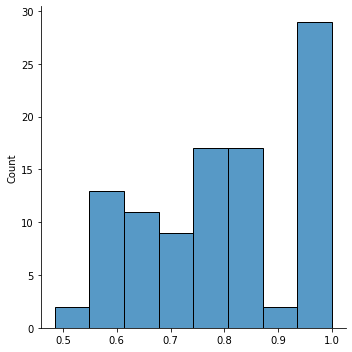

In [15]:
import spacy

#spacy is a free industrial-strenth NLP in python (https://spacy.io/)
#en_core_web_sm is an english pipeline optimized for cpu.  components: tok2vec, tagger, prser, senter, ner, attribure_rulter, lemmantizer

nlp = spacy.load('en_core_web_sm')  #the nlp is going to tokenize the lists dt_b, dt_a
#nlp = spacy.load('en')

dt_b = subset["response"]  #109 responses (from our google form) in our response.csv
dt_a = [next(t) for i in range(100)]  #created sentences from 3 models that were combined.  Remember the 3 models were (created) based on the the reponse.csv issues (categories)

import numpy as np
a = []
for sentence in dt_a:
    doc = nlp(sentence)
    m = 0
    for sentence1 in dt_b:
        doc1 = nlp(sentence1)
        if m < doc.similarity(doc1):
            m = doc.similarity(doc1)  #m is taking the highest similarity of all the comparisons made  (a[] is a bunch of numbers between 1 and -1)
    a.append(m)
        
print("Mean similarity: " + str(np.array(a).mean()))
print(a)

import seaborn as sns
sns.displot(a)

#plotting generated sentences vs google form sentences.  For each google form sentence, what was the most similiar in the list of generated sentences.
#have a fairly normal distributation which demonstrates that our nlp generation isn't bad :)

In [34]:
import cProfile

def timing(c):
    for _ in range(c):
        next(t)

cProfile.run('timing(2000)', 'generatestats')

In [35]:
import pstats
p = pstats.Stats('generatestats')
p.strip_dirs().sort_stats(-1).print_stats()

Sun Mar 21 22:33:22 2021    generatestats

         294240 function calls (269838 primitive calls) in 0.157 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     2000    0.002    0.000    0.009    0.000 <ipython-input-10-5f1382f3447f>:13(choose_model)
     2000    0.001    0.000    0.156    0.000 <ipython-input-10-5f1382f3447f>:2(generate_cases)
     2000    0.002    0.000    0.145    0.000 <ipython-input-24-d930d16f82f3>:6(make_sentence)
        1    0.001    0.001    0.157    0.157 <ipython-input-34-801ca619797e>:3(timing)
        1    0.000    0.000    0.157    0.157 <string>:1(<module>)
    61849    0.017    0.000    0.025    0.000 chain.py:10(accumulate)
    26435    0.019    0.000    0.122    0.000 chain.py:112(gen)
     2033    0.006    0.000    0.128    0.000 chain.py:125(walk)
    26435    0.065    0.000    0.103    0.000 chain.py:96(move)
     2033    0.001    0.000    0.002    0.000 text.py:120(word_join)
     203